# OLIVIA
**Open-source Library Indexes Vulnerability Identification and Analysis**

The use of centralized library repositories to reduce development times and costs is universal, in virtually all languages and types of software projects. Due to the transitivity of dependencies, the appearance of a single defect in the repository can have extensive and difficult-to-predict effects on the ecosystem. These defects cause functional errors or performance or security problems. The risk is difficult to grasp for developers, who only explicitly import a small part of the dependencies.

OLVIA uses an approach based on the vulnerability of the dependency network of software packages, which measures how sensitive the repository is to the random introduction of defects. The goals of the model are  to contribute to the understanding of propagation mechanisms of software defects and to study feasible protection strategies. This can benefit multiple parties:

* **Centralised package managers**, to establish policies and manual or automatic control processes that improve the security and stability of the repositories.
* **Software developers** in general, to assess the different risks introduced by the dependencies used in their projects, and **package developers** in particular to understand their responsibility on the ecosystem.
* Developers of **continuous quality tools**, to define the concept of vulnerability based on the modeling of the network of package dependencies.
---

**Author**: Daniel Setó Rey

https://github.com/dsr0018/olivia

**License**: Olivia and this notebook are published under a MIT [license](https://github.com/dsr0018/olivia/blob/master/LICENSE). The information of dependencies has been obtained from the libraries.io [data snapshots](https://libraries.io/data) (by Tidelift).

***
*This notebook is part of a user guide series that cover in detail the operation of the library.
Here we study the dependency relations between packages and the vulnerability of the network.*



## B - Analysis

[01 - Coupling](#01---Coupling)&ensp;|&ensp;[02 - Strongly connected components](#02---Strongly-connected-components)&ensp;|&ensp;[03 - Network vulnerability](#03---Network-vulnerability)

Simply saying that one package depends transitively on another does not tell the whole story. A defect in one package can affect another in different ways, depending on the structure of the network.

### 01 - Coupling

In [2]:
from olivia.model import OliviaNetwork

pypi = OliviaNetwork(r'data/pypi-2020-01-12.olv')

Let's choose a simple case study.

*spaCy* (https://spacy.io/) is an open-source software library for advanced natural language processing.

In [33]:
pypi['spacy'].direct_dependencies()

{'blis',
 'cloudpickle',
 'cymem',
 'dill',
 'ftfy',
 'html5lib',
 'msgpack-numpy',
 'msgpack-python',
 'murmurhash',
 'numpy',
 'pathlib',
 'pip',
 'plac',
 'preshed',
 'regex',
 'requests',
 'six',
 'sputnik',
 'srsly',
 'text_unidecode',
 'thinc',
 'ujson',
 'unidecode',
 'wasabi',
 'wget'}

*spaCy* employs 25 direct dependencies. These are the ones that the developers have explicitly imported, for example *requests*, a useful HTTP library. It should be clear to them that they take a risk by using *requests*. If it disappear, or include a bug or a vulnerability that their developers don't fix, the *spaCy* developers will have a problem. They would have to look for alternatives or perhaps directly implement the *requests* functionality.

However, *spaCy* indirectly depends on more packages:

In [34]:
len(pypi['spacy'].transitive_dependencies())

73

So there are not 25 but 73 packages that can cause trouble.  This is a fact that many developers may be aware of, although it is maybe not generally considered seriously enough.

There is however another more elusive phenomenon. This is the fact that a single failure in a transitive dependency can affect several direct dependencies, if the latter depend in turn on the first. So *spaCy* does not depend equally on all its transitive dependencies.

**Transitive coupling** is the number of direct dependencies that would be affected by the failure of one specific transitive dependency. Observe for example the following figure, where a defect in *u* will affect 3 of the 4 direct dependencies of *v*:

<br>

![Transitive coupling](docs/img/trancoup.png "Transitive coupling")  

<br>

In [35]:
from olivia.coupling import *

transitive_coupling(pypi,'six','spacy')

4

There it is. The failure of *six* does not only affect one direct dependency, but four. Which ones? We call this set the **coupling interface** of *six* over *spaCy*.

In [37]:
coupling_interface(pypi,'six','spacy')

{'ftfy', 'html5lib', 'six', 'thinc'}

So let's consider that *six* changes its MIT license for a more restrictive one. Its transitional dependents in turn are forced to upgrade and ultimately *ftfy*, *html5lib*, *thinc* also change their software licenses.  If *spaCY* cannot or do not want to comply with this new model, it has to look for alternatives for *six* and also *ftfy*, *html5lib* and *thinc*. 

This change of license in *six* could also have been a shift in functionality, the removal of certain certification, a bug, a security problem... Transitive coupling is a measure of the potential effort needed to fix *spaCY* if *six* fails. Note that the sum of transitive couplings of a package with all its transitive dependants equals the IMPACT metric.

Finally, OLIVIA provides a method for computing all the transitive interfaces of transitive dependencies of a package over it. This is an indexed family of sets that we call **coupling profile**:


In [38]:
coupling_profile(pypi,'spacy')

{'click': {'thinc'},
 'wcwidth': {'ftfy'},
 'six': {'ftfy', 'html5lib', 'six', 'thinc'},
 'html5lib': {'ftfy', 'html5lib'},
 'text_unidecode': {'text_unidecode'},
 'requests': {'requests'},
 'thinc': {'thinc'},
 'flexmock': {'thinc'},
 'idna': {'requests'},
 'typing_extensions': {'thinc'},
 'filelock': {'thinc'},
 'itertoolz': {'thinc'},
 'chainer': {'thinc'},
 'enum34': {'thinc'},
 'ftfy': {'ftfy'},
 'protobuf': {'thinc'},
 'setuptools_git': {'thinc'},
 'certifi': {'requests'},
 'msgpack-python': {'msgpack-numpy', 'msgpack-python', 'thinc'},
 'tqdm': {'thinc'},
 'sortedcontainers': {'thinc'},
 'msgpack-numpy': {'msgpack-numpy', 'thinc'},
 'sputnik': {'sputnik'},
 'pathlib': {'pathlib', 'thinc'},
 'packaging': {'ftfy', 'html5lib', 'thinc'},
 'uncompyle6': {'thinc'},
 'cytoolz': {'thinc'},
 'scandir': {'thinc'},
 'funcsigs': {'thinc'},
 'chardet2': {'requests'},
 'wrapt': {'thinc'},
 'coverage': {'thinc'},
 'wasabi': {'thinc', 'wasabi'},
 'toolz': {'thinc'},
 'cupy': {'thinc'},
 'plac':

The frequency histogram of transitive coupling values for a package is an interesting view of the structure of dependencies:

Text(0.5, 1.0, 'package: spacy')

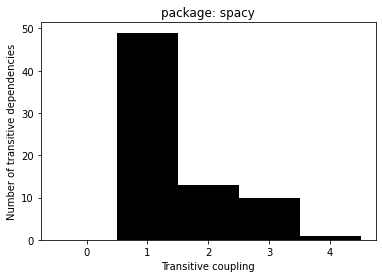

In [66]:
# Requires Matplotlib installed
import matplotlib.pyplot as plt

cp = coupling_profile(pypi,'spacy')
ls = [len(cp[l]) for l in cp]
bins = np.arange(0, max(ls) + 1.5) - 0.5
plt.hist(ls,bins,color='black',histtype='stepfilled')
plt.xlabel('Transitive coupling')
plt.ylabel('Number of transitive dependencies')
plt.title('package: spacy')

You may also access coupling methods via *PackageInfoView*:

In [68]:
pypi['spacy'].coupling_interface_from('six')

{'ftfy', 'html5lib', 'six', 'thinc'}

In [69]:
pypi['six'].coupling_interface_to('spacy')

{'ftfy', 'html5lib', 'six', 'thinc'}

In [72]:
pypi['spacy'].coupling_profile()

{'click': {'thinc'},
 'wcwidth': {'ftfy'},
 'six': {'ftfy', 'html5lib', 'six', 'thinc'},
 'html5lib': {'ftfy', 'html5lib'},
 'text_unidecode': {'text_unidecode'},
 'requests': {'requests'},
 'thinc': {'thinc'},
 'flexmock': {'thinc'},
 'idna': {'requests'},
 'typing_extensions': {'thinc'},
 'filelock': {'thinc'},
 'itertoolz': {'thinc'},
 'chainer': {'thinc'},
 'enum34': {'thinc'},
 'ftfy': {'ftfy'},
 'protobuf': {'thinc'},
 'setuptools_git': {'thinc'},
 'certifi': {'requests'},
 'msgpack-python': {'msgpack-numpy', 'msgpack-python', 'thinc'},
 'tqdm': {'thinc'},
 'sortedcontainers': {'thinc'},
 'msgpack-numpy': {'msgpack-numpy', 'thinc'},
 'sputnik': {'sputnik'},
 'pathlib': {'pathlib', 'thinc'},
 'packaging': {'ftfy', 'html5lib', 'thinc'},
 'uncompyle6': {'thinc'},
 'cytoolz': {'thinc'},
 'scandir': {'thinc'},
 'funcsigs': {'thinc'},
 'chardet2': {'requests'},
 'wrapt': {'thinc'},
 'coverage': {'thinc'},
 'wasabi': {'thinc', 'wasabi'},
 'toolz': {'thinc'},
 'cupy': {'thinc'},
 'plac':

### 02 - Strongly connected components

An strongly connected component (SCC) is a set of packages where each one depends transitively on every one else. So a defect in any package or in any dependency of any package in the SCC could affect the whole SCC.

A simple cycle of dependencies creates an SCC, but there can be much more complicated ones.

This is an example of a simple SCC:

<br>

![SCC](docs/img/scc.png "Strongly connected component")  

<br>

As OLIVIA internally uses the precomputed structure of SCCs of the dependency network, you can iterate immediatly over SCCs: 

In [97]:
scc_iterator = pypi.sccs()
print(next(scc_iterator))
print(next(scc_iterator))
print(next(scc_iterator))
print("...")

{'1pass'}
{'simple-pbkdf2'}
{'Alarmageddon'}
...


Each package forms its own SCC. PyPI has some small SCCs of size greater than one. These are the most interesting so OLIVIA provides a way of getting a list of SCCs in size order:

In [83]:
pypi.sorted_clusters()[:10]

[{'aws-cdk.assets',
  'aws-cdk.aws-lambda',
  'aws-cdk.aws-s3',
  'aws-cdk.aws-s3-assets',
  'aws-cdk.aws-s3-notifications',
  'aws-cdk.aws-sns',
  'aws-cdk.aws-sqs'},
 {'cloudtoken',
  'cloudtoken-plugin.json-exporter',
  'cloudtoken-plugin.saml',
  'cloudtoken-plugin.shell-exporter'},
 {'dash', 'dash-core-components', 'dash-html-components', 'dash-table'},
 {'SimpleSQLite', 'pytablereader', 'pytablewriter', 'sqliteschema'},
 {'classutils', 'configurationutil', 'fdutil', 'uiutil'},
 {'joker', 'joker-broker', 'joker-cast', 'joker-textmanip'},
 {'cs.debug', 'cs.queues', 'cs.result', 'cs.threads'},
 {'ogc', 'ogc-plugins-env', 'ogc-plugins-runner'},
 {'databasetools', 'dirutility', 'mysql-toolkit'},
 {'indb', 'metadb', 'metaform'}]

It is also possible to query which SCC a package belongs to, via PackageInfoView:

In [85]:
pypi['indb'].scc()

{'indb', 'metadb', 'metaform'}

It turns out that some networks have much larger SCCs

In [86]:
maven = OliviaNetwork(r'data/maven-2020-01-12.olv')

Maven Central, the package repository for Java (https://mvnrepository.com/) has a SCC of almost a thousand packages:

In [89]:
len(maven.sorted_clusters()[0])

981

### 03 - Network vulnerability

The vulnerability of the dependency network of software packages measures how sensitive the repository is to the random introduction of defects.

It is the average of some cost function over all the packages in the network, so it equals the expected cost of a random failure o defect, assuming a uniform failure probability.

We may use REACH as one of such cost functions. In this case, the vulnerability value would represent the expected number of packages potentially affected by a random failure.

The following figure shows several examples of simple networks with node values for REACH (R) and IMPACT (I) and below the corresponding REACH and IMPACT-vulnerability (preceded by the letter $\varphi$)

<br>

![Transitive coupling](docs/img/vulnerabilidad.png "Transitive coupling")  

<br>

In [91]:
from olivia.networkmetrics import *

failure_vulnerability(pypi)

Computing Reach
     Processing node: 50K      


15.730114643659142

*failure_vulnerability* assumes REACH as cost function. As this model does not have a REACH cached, it is computed on the fly.  The calculation uses exact cost function values for each package in the network.  usually these functions have extremely skewed distributions, so average value is hard to sample.

PyPI has a REACH-vulnerability of about 16. This means that a random bug in a package could propagate in average to other 15 packages.

Maven is much more vulnerable to random failures, due to the presence of a significant size SCC.

In [92]:
failure_vulnerability(maven)

Computing Reach
     Processing node: 124K      


1805.5391236430194

In [93]:
len(maven)

126752

Even considering the size difference, this is much worse that PyPI. At least other network, npm (https://www.npmjs.com/), the repository of Node.js, has even bigger relative values.

Other cost functions provide different perspectives on network vulnerability:

In [96]:
from olivia.packagemetrics import Impact

failure_vulnerability(pypi, metric=Impact)

Computing Impact
     Processing node: 50K      


23.16392861363905

A single random failure on PyPI causes a expected potential value of 23 individual dependencies to fix. As REACH-vulnerability could reflect the propagation of defects, IMPACT-vulnerability gives an idea of the average effort needed to recover the network.